In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.python.keras import backend as k

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from tensorflow.keras import backend

from utils import * 
from config import parameters

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
import math
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

2.0.0
base_dir: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
Parameters(
  sentence_length_outlier = [0, 1, 2, 181, 252]
  bigram_window_size = 15
  bigram_max_rank = None
  stopword_list = ['financial', 'market', 'federal', 'bank', 'banking', 'bankers', 'speech', 'bi', 'review', 'year', 'reserve', 'policy', 'state', 'central', 'board', 'percent', 'rate', 'mr', 'alan', 'greenspan', 'ben', 'bernanke', 'janet', 'yellen', 'jerome', 'powell', 'vol', 'ha', 'wa', 'ii']
  ws_quarterly = 4
  ws_semiannually = 2
  ws_annually = 1
  strength_alpha = 0.9
  base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
  data_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data
  output_base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output
  bis_raw_csv_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data/bis_w_content_FINAL_20191213.csv
  fred_gdp_quarterly_csv_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_freque

In [2]:
def rescale_rolling(values, rolling_window):
    df = pd.DataFrame(values)
    normalized = (df - df.rolling(rolling_window).mean()) / df.rolling(rolling_window).std()
    return normalized

# ALIGN: convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :].reshape(-1)
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

def series_to_supervised(values, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(values) is list else values.shape[1]
    df = DataFrame(values)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in columns]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in columns]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
def main(x1_index_name, index_name, num_epochs=30):
    print('x1_index_name:', x1_index_name)
    print('index_name:', index_name)
    
    if index_name == 'unemployment_not_adjusted':
        pkl_file_path = 'topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl'
    elif index_name == 'inflation_rate_percentage_change':
        pkl_file_path = 'inflation_rolling_3_period_x_y_dict.pkl'
    processed_list_pkl_filepath = os.path.join(parameters.output_base_dir, pkl_file_path) 
    [period_dict, proposed_data_x_dict, fred_data_y_dict] = load_pkl(processed_list_pkl_filepath)
    print('Training(%d): %s - %s' % (n_train_num, period_dict[index_name][:n_train_num][0], period_dict[index_name][:n_train_num][-1]))
    print('Test(%d): %s - %s' % (len(period_dict[index_name])-n_train_num, period_dict[index_name][n_train_num], period_dict[index_name][-1]))
    
    y = pd.Series(fred_data_y_dict[index_name])
    # y = rescale_rolling(y, 3)

    x1, dataset = None, None
    if x1_index_name is not None:
        x1 = pd.Series(proposed_data_x_dict[x1_index_name][index_name])
        # x1 = rescale_rolling(x1, 3)
        dataset = pd.concat([x1, y], axis=1)
        dataset.columns = x1_index_name, index_name
    else:
        dataset = pd.DataFrame(y, columns=[index_name])

    feature_num = dataset.shape[1]
    values = dataset.values   # pd.Series -> numpy.ndarray

    # integer encode direction
    # encoder = LabelEncoder()
    # values[:,feature_num - 1] = encoder.fit_transform(values[:,feature_num - 1])

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, dataset.columns, 1, 1)   # scaled, values

    # drop columns we don't want to predict
    drop_cols = [colname for colname in reframed.columns if '(t)' in colname and index_name not in colname]
    reframed.drop(drop_cols, axis=1, inplace=True)

    # split into train and test sets
    values = reframed.values
    train = values[:n_train_num, :]
    test = values[n_train_num:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # design network
    model = Sequential()
    model.add(LSTM(64, input_shape=(train_X.shape[1:])))
#     model.add(Dense(500))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, shuffle=False,
    batch_size=1,
    epochs=num_epochs,
    validation_split=0.1,
#     callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=1)

    # plot history
    fig = plt.figure()
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    # inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    #inv_yhat = scaler.inverse_transform(inv_yhat)
    #inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
#     test_y = test_y.reshape((len(test_y), 1))
#     inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    #inv_y = scaler.inverse_transform(inv_y)
    #inv_y = inv_y[:,0]

    # calculate RMSE
    # rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse = sqrt(mean_squared_error(test_y, yhat))
    print('Test RMSE: %.4f' % rmse)

    fig.savefig('../output/image/%s_train%d_feature%d_%s_%.4f.png' % (index_name, n_train_num, feature_num, x1_index_name, rmse))

In [14]:
# parameters
index_name = 'unemployment_not_adjusted'   # inflation_rate_percentage_change
pkl_file_path = 'topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl'   #  inflation_rolling_3_period_x_y_dict.pkl

x1_index_name = None   # None, 'frequency', 'strength', 'emerging_topic_score'

n_train_num = 50

x1_index_name: None
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1459 - val_loss: 0.0715
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0732 - val_loss: 0.0509
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0564 - val_loss: 0.0509
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0501 - val_loss: 0.0489
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0448 - val_loss: 0.0462
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0465 - val_loss: 0.0424
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0399 - val_loss: 0.0407
Epoch

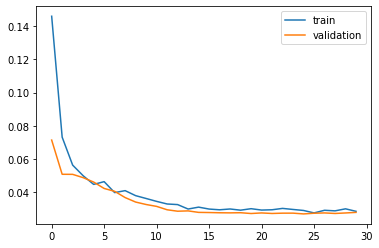

Test RMSE: 0.1467


In [15]:
main(None, 'unemployment_not_adjusted')

x1_index_name: frequency
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1314 - val_loss: 0.0600
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0599 - val_loss: 0.0462
Epoch 3/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0516 - val_loss: 0.0450
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0531 - val_loss: 0.0422
Epoch 5/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0502 - val_loss: 0.0402
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0495 - val_loss: 0.0385
Epoch 7/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0440 - val_loss: 0.0370


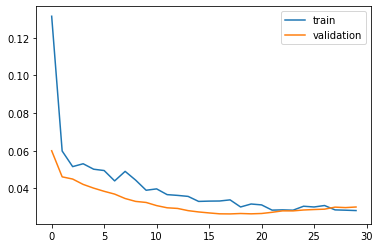

Test RMSE: 0.1386


In [16]:
main('frequency', 'unemployment_not_adjusted')

x1_index_name: strength
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 47ms/sample - loss: 0.1188 - val_loss: 0.0606
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0630 - val_loss: 0.0523
Epoch 3/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0563 - val_loss: 0.0504
Epoch 4/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0519 - val_loss: 0.0484
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0522 - val_loss: 0.0459
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0480 - val_loss: 0.0446
Epoch 7/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0492 - val_loss: 0.0425
E

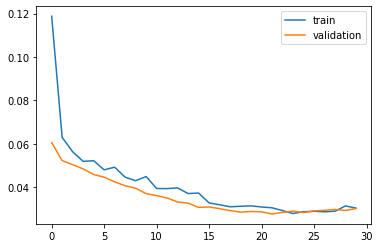

Test RMSE: 0.1317


In [17]:
main('strength', 'unemployment_not_adjusted')

x1_index_name: emerging_topic_score
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1151 - val_loss: 0.0442
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0552 - val_loss: 0.0379
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0554 - val_loss: 0.0360
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0485 - val_loss: 0.0340
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0451 - val_loss: 0.0311
Epoch 6/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0429 - val_loss: 0.0293
Epoch 7/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0459 - val_lo

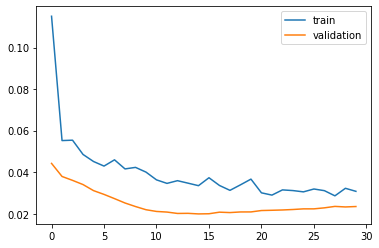

Test RMSE: 0.1449


In [18]:
main('emerging_topic_score', 'unemployment_not_adjusted')

### Inflation

x1_index_name: None
index_name: inflation_rate_percentage_change
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl
Training(50): 1998_Q2 - 2010_Q4
Test(24): 2011_Q1 - 2016_Q4
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 48ms/sample - loss: 0.1970 - val_loss: 0.1240
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0774 - val_loss: 0.0810
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0382 - val_loss: 0.0837
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0300 - val_loss: 0.0856
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0331 - val_loss: 0.0841
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0323 - val_loss: 0.0834
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0322 - val_loss: 0.0827
Epoch 8/

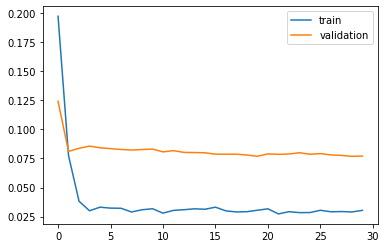

Test RMSE: 0.1332


In [19]:
main(None, 'inflation_rate_percentage_change')

x1_index_name: frequency
index_name: inflation_rate_percentage_change
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl
Training(50): 1998_Q2 - 2010_Q4
Test(24): 2011_Q1 - 2016_Q4
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 37ms/sample - loss: 0.1432 - val_loss: 0.0874
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0405 - val_loss: 0.0824
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0313 - val_loss: 0.0831
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0359 - val_loss: 0.0805
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0344 - val_loss: 0.0816
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0341 - val_loss: 0.0810
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0325 - val_loss: 0.0820
Epo

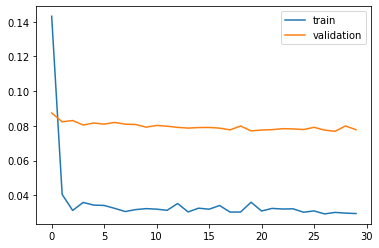

Test RMSE: 0.1402


In [20]:
main('frequency', 'inflation_rate_percentage_change')

x1_index_name: strength
index_name: inflation_rate_percentage_change
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl
Training(50): 1998_Q2 - 2010_Q4
Test(24): 2011_Q1 - 2016_Q4
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1919 - val_loss: 0.0969
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0498 - val_loss: 0.0812
Epoch 3/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0331 - val_loss: 0.0854
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0316 - val_loss: 0.0858
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0318 - val_loss: 0.0851
Epoch 6/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0324 - val_loss: 0.0827
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0305 - val_loss: 0.0864
Epoc

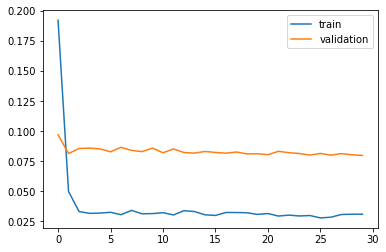

Test RMSE: 0.1388


In [21]:
main('strength', 'inflation_rate_percentage_change')

x1_index_name: emerging_topic_score
index_name: inflation_rate_percentage_change
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl
Training(50): 1998_Q2 - 2010_Q4
Test(24): 2011_Q1 - 2016_Q4
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 37ms/sample - loss: 0.1899 - val_loss: 0.0987
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0483 - val_loss: 0.0758
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0326 - val_loss: 0.0795
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0336 - val_loss: 0.0780
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0342 - val_loss: 0.0771
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0339 - val_loss: 0.0787
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0328 - val_loss:

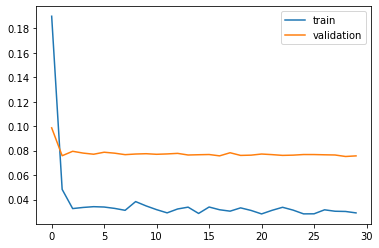

Test RMSE: 0.1383


In [22]:
main('emerging_topic_score', 'inflation_rate_percentage_change')

x1_index_name: strength
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/100
45/45 [==============================] - 2s 38ms/sample - loss: 0.1453 - val_loss: 0.0658
Epoch 2/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0654 - val_loss: 0.0509
Epoch 3/100
45/45 [==============================] - 0s 6ms/sample - loss: 0.0546 - val_loss: 0.0500
Epoch 4/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0533 - val_loss: 0.0475
Epoch 5/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0489 - val_loss: 0.0454
Epoch 6/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0467 - val_loss: 0.0439
Epoch 7/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0439 - val_loss: 0

45/45 [==============================] - 0s 5ms/sample - loss: 0.0274 - val_loss: 0.0315
Epoch 79/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0268 - val_loss: 0.0315
Epoch 80/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0255 - val_loss: 0.0321
Epoch 81/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0275 - val_loss: 0.0314
Epoch 82/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0294 - val_loss: 0.0314
Epoch 83/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0288 - val_loss: 0.0314
Epoch 84/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0279 - val_loss: 0.0321
Epoch 85/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0257 - val_loss: 0.0315
Epoch 86/100
45/45 [==============================] - 0s 6ms/sample - loss: 0.0283 - val_loss: 0.0317
Epoch 87/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0281 - val_loss: 

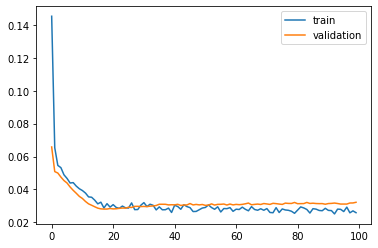

Test RMSE: 0.1295


In [26]:
main('strength', 'unemployment_not_adjusted', num_epochs=100)